In [26]:
import pickle
import numpy as np
from rul_calce_data import individual_battery_run 
from utility import cal_ttf

def rul_battery(t, y, name):
    # Calculate true TTF.
    threshold = .7*1.1
    true_ttf, idx_ttf = cal_ttf(t, y, threshold)
    t = t[:idx_ttf+10]
    y = y[:idx_ttf+10]
    T = len(t) # Number of time steps
    
    # Define the Parameters.
    # For the PF.
    sigma_u = np.array([1e-2, 1e-5, 1e-4, 1e-3])
    sigma_v = 1e-2
    Ns = 1e3
    # For the RUL prediction.
    max_ite = 60 # Maximun number of prediction states.
    max_RUL = 60 # RUL when not failure found.
    idx_start = 50
    step = 1
    idx_pred = np.arange(idx_ttf-idx_start, idx_ttf+step, step, dtype=int) # Index of the prediction instants.
    # Create the time.
    t_pred = np.arange(t[-1]+1, t[-1] + max_ite + 1, 1) 
    t_pred = np.concatenate((t, t_pred))
    
    xh, yh, y_bands, rul_mean, rul_bands, rul, rul_weights = individual_battery_run(t, y, sigma_u, sigma_v, Ns, threshold, idx_ttf, idx_pred, t_pred, max_ite, max_RUL)

    # Save the result.
    file_name = 'result_' + name + '.pickle'
    with open(file_name, 'wb') as f:
        pickle.dump([t, y, threshold, idx_ttf, idx_pred, true_ttf, max_RUL, 
            xh, yh, y_bands, rul_mean, rul_bands, rul, rul_weights
        ], f, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# Run particle filtering to estimate the state variables.
battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
# Directly read from the archived data.
with open('data_all.pickle', 'rb') as f:
    data_all = pickle.load(f)

# CS2_35

100%|██████████| 51/51 [00:55<00:00,  1.10s/it]


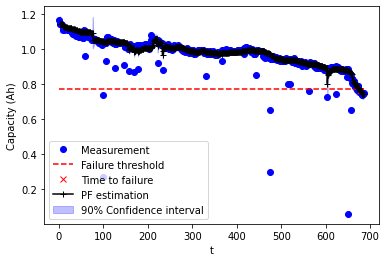

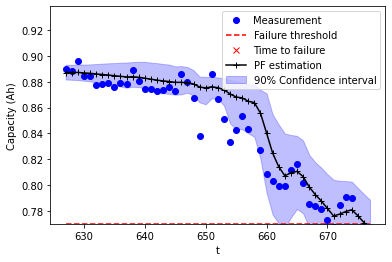

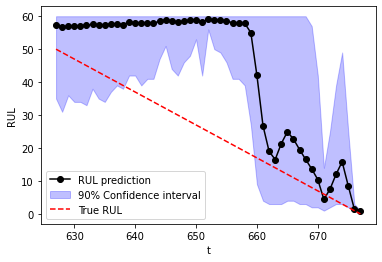

LinAlgError at 
50


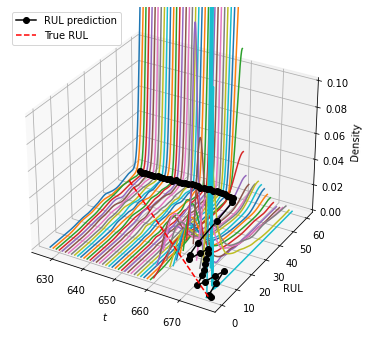

In [24]:
from utility import drop_outlier_sw

name = battery_list[0]
battery = data_all[name]
# Get the time and degradation measurement. Perform filtering.
t = battery['cycle']
y = battery['charging capacity']
t = np.array(t)
y = np.array(y)

# rolling_window = 20
# idx = drop_outlier_sw(y, rolling_window)
# t = np.array(t[idx])
# y = np.array(y[idx])

rul_battery(t, y, name)

# CS2_36

100%|██████████| 51/51 [00:23<00:00,  2.13it/s]


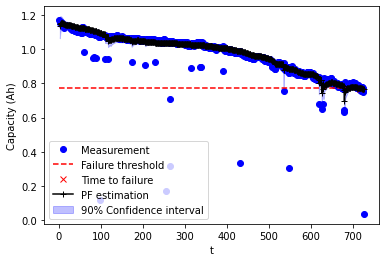

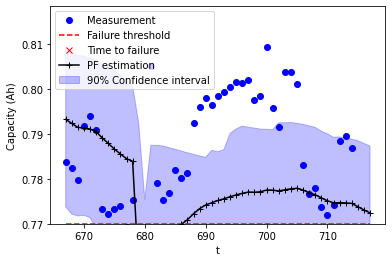

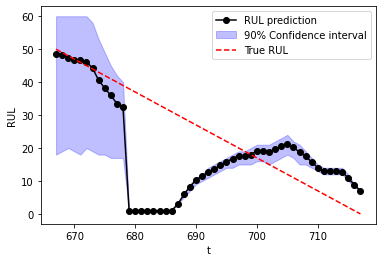

LinAlgError at 
12
LinAlgError at 
13
LinAlgError at 
14
LinAlgError at 
15
LinAlgError at 
16
LinAlgError at 
17
LinAlgError at 
18
LinAlgError at 
19


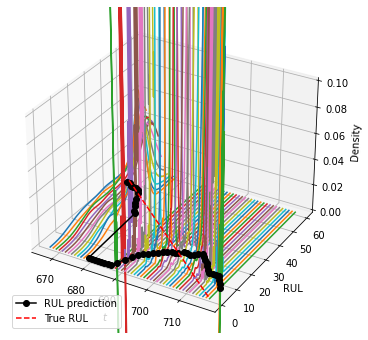

In [27]:
from utility import drop_outlier_sw

name = battery_list[1]
battery = data_all[name]
# Get the time and degradation measurement. Perform filtering.
t = battery['cycle']
y = battery['charging capacity']
t = np.array(t)
y = np.array(y)

# rolling_window = 20
# idx = drop_outlier_sw(y, rolling_window)
# t = np.array(t[idx])
# y = np.array(y[idx])

rul_battery(t, y, name)

# CS_37

100%|██████████| 51/51 [00:45<00:00,  1.12it/s]


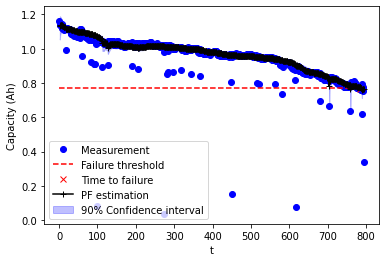

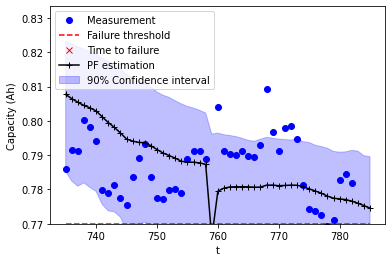

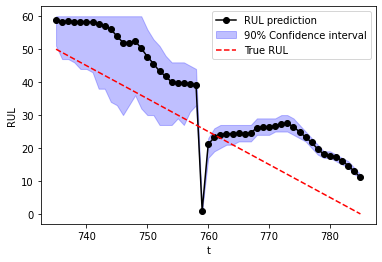

LinAlgError at 
24


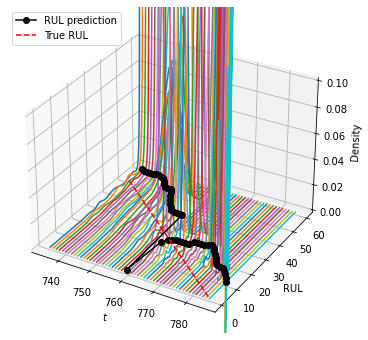

In [28]:
from utility import drop_outlier_sw

name = battery_list[2]
battery = data_all[name]
# Get the time and degradation measurement. Perform filtering.
t = battery['cycle']
y = battery['charging capacity']
t = np.array(t)
y = np.array(y)

# rolling_window = 20
# idx = drop_outlier_sw(y, rolling_window)
# t = np.array(t[idx])
# y = np.array(y[idx])

rul_battery(t, y, name)

# CS_38

100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


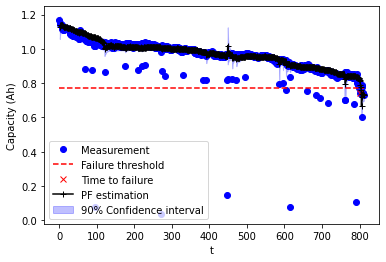

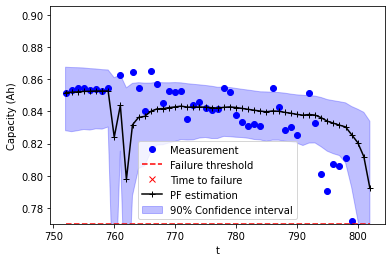

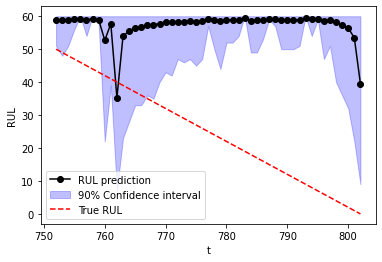

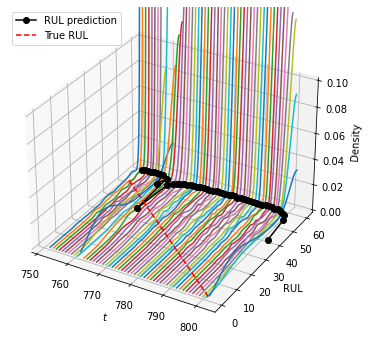

In [29]:
from utility import drop_outlier_sw

name = battery_list[3]
battery = data_all[name]
# Get the time and degradation measurement. Perform filtering.
t = battery['cycle']
y = battery['charging capacity']
t = np.array(t)
y = np.array(y)

# rolling_window = 20
# idx = drop_outlier_sw(y, rolling_window)
# t = np.array(t[idx])
# y = np.array(y[idx])

rul_battery(t, y, name)